## Importing libraries

In [45]:
!pip install xgboost
!pip install scikit-optimize

In [46]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## XGBoost implementation

### Preparing the Dataset

In [48]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

In [49]:
# adding features that make more sense than raw data
all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

for lag in range(1, 4):
  all_prices[f"Gold_lag_{lag}"] = all_prices["Gold"].shift(lag)
  all_prices[f"Silver_lag_{lag}"] = all_prices["Silver"].shift(lag)
  all_prices[f"CAD_lag_{lag}"] = all_prices["CAD"].shift(lag)

In [50]:
# price to predict, the price of the next timestep
all_prices["Gold_target"] = all_prices["Gold"].shift(-1)
all_prices["Silver_target"] = all_prices["Silver"].shift(-1)
all_prices["CAD_target"] = all_prices["CAD"].shift(-1)

In [51]:
all_prices = all_prices.dropna()

In [52]:
all_prices.head()

,Datetime,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
4,2025-10-03 01:00:00+00:00,3868.0,46.805,0.716014,0.0,0.0,-0.000136,3868.0,46.805,0.716152,...,0.716112,3868.0,46.805,0.716132,3868.0,46.805,0.716286,3868.0,46.805,0.716199
5,2025-10-03 01:30:00+00:00,3868.0,46.805,0.716199,0.0,0.0,0.000258,3868.0,46.805,0.716149,...,0.716014,3868.0,46.805,0.716112,3868.0,46.805,0.716132,3868.0,46.805,0.716071
6,2025-10-03 02:00:00+00:00,3868.0,46.805,0.716071,0.0,0.0,-0.000179,3868.0,46.805,0.716106,...,0.716199,3868.0,46.805,0.716014,3868.0,46.805,0.716112,3868.0,46.805,0.715989
7,2025-10-03 02:30:00+00:00,3868.0,46.805,0.715989,0.0,0.0,-0.000115,3868.0,46.805,0.716077,...,0.716071,3868.0,46.805,0.716199,3868.0,46.805,0.716014,3868.0,46.805,0.715876
8,2025-10-03 03:00:00+00:00,3868.0,46.805,0.715876,0.0,0.0,-0.000158,3868.0,46.805,0.716030,...,0.715989,3868.0,46.805,0.716071,3868.0,46.805,0.716199,3868.0,46.805,0.716025


In [53]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 4 to 1975
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       1972 non-null   object 
 1   Gold           1972 non-null   float64
 2   Silver         1972 non-null   float64
 3   CAD            1972 non-null   float64
 4   Gold_ret       1972 non-null   float64
 5   Silver_ret     1972 non-null   float64
 6   CAD_ret        1972 non-null   float64
 7   Gold_ma        1972 non-null   float64
 8   Silver_ma      1972 non-null   float64
 9   CAD_ma         1972 non-null   float64
 10  Gold_lag_1     1972 non-null   float64
 11  Silver_lag_1   1972 non-null   float64
 12  CAD_lag_1      1972 non-null   float64
 13  Gold_lag_2     1972 non-null   float64
 14  Silver_lag_2   1972 non-null   float64
 15  CAD_lag_2      1972 non-null   float64
 16  Gold_lag_3     1972 non-null   float64
 17  Silver_lag_3   1972 non-null   float64
 18  CAD_lag_3    

In [54]:
all_prices.describe()

,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_lag_1,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1.972000e+03,1972.000000,1972.000000,1972.000000,1972.000000,...,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,4093.744728,49.804212,0.713097,0.000053,0.000115,-1.741805e-07,4093.333309,49.792968,0.713097,4093.538593,...,0.713097,4093.332812,49.792929,0.713097,4093.129110,49.787432,0.713097,4093.953907,49.809839,0.713096
std,103.517455,2.146453,0.002498,0.002362,0.003876,3.716845e-04,103.253461,2.125859,0.002487,103.562057,...,0.002498,103.606849,2.132900,0.002499,103.654798,2.126612,0.002499,103.477823,2.153118,0.002498
min,3867.199951,45.665001,0.707269,-0.014739,-0.039054,-2.118744e-03,3867.839990,45.844000,0.707599,3867.199951,...,0.707269,3867.199951,45.665001,0.707269,3867.199951,45.665001,0.707269,3867.199951,45.665001,0.707269
25%,4012.300049,48.130001,0.711737,-0.000929,-0.001452,-1.995682e-04,4011.810010,48.120750,0.711752,4012.250061,...,0.711737,4012.075073,48.125000,0.711737,4011.950012,48.123750,0.711737,4012.300049,48.130001,0.711737
50%,4078.300049,49.414999,0.713071,0.000000,0.000000,0.000000e+00,4077.140039,49.392500,0.713087,4078.250000,...,0.713071,4078.199951,49.387501,0.713071,4078.199951,49.362501,0.713071,4078.300049,49.422499,0.713071
75%,4162.949951,51.131250,0.714686,0.001175,0.001964,2.000989e-04,4159.770044,51.128499,0.714694,4162.899902,...,0.714686,4162.675049,51.125000,0.714686,4162.074951,51.121249,0.714686,4163.300049,51.134998,0.714686
max,4394.299805,58.564999,0.719746,0.014620,0.045237,2.381740e-03,4383.499902,58.226000,0.719653,4394.299805,...,0.719746,4394.299805,58.564999,0.719746,4394.299805,58.564999,0.719746,4394.299805,58.564999,0.719746


In [55]:
X = all_prices.drop(columns=["Datetime", 'Gold_target', 'Silver_target', 'CAD_target'])
y = all_prices[['Gold_target', 'Silver_target', 'CAD_target']]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

### XGBoost experimenting

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [58]:
num_round = 15
param = {
    'learning_rate': 0.5,
    'max_depth': 30,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:31.46378	eval-rmse:30.35551
[1]	train-rmse:16.57448	eval-rmse:18.39023
[2]	train-rmse:9.19702	eval-rmse:14.14728
[3]	train-rmse:5.39084	eval-rmse:12.92567
[4]	train-rmse:3.29255	eval-rmse:12.10340
[5]	train-rmse:2.07162	eval-rmse:11.79071
[6]	train-rmse:1.34099	eval-rmse:11.47417
[7]	train-rmse:0.89626	eval-rmse:11.32394
[8]	train-rmse:0.61856	eval-rmse:11.17372
[9]	train-rmse:0.43392	eval-rmse:11.07969
[10]	train-rmse:0.30977	eval-rmse:11.02368
[11]	train-rmse:0.22050	eval-rmse:10.98812
[12]	train-rmse:0.15896	eval-rmse:10.97389
[13]	train-rmse:0.11458	eval-rmse:10.96754
[14]	train-rmse:0.08463	eval-rmse:10.96098


In [59]:
y_pred = bst.predict(dtest)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

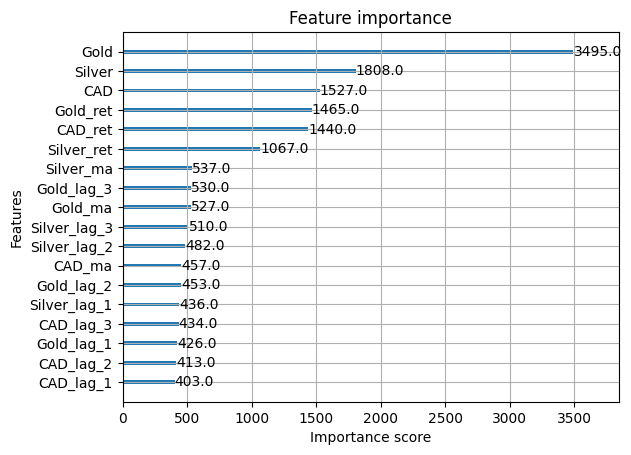

In [60]:
xgb.plot_importance(bst)

In [61]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [62]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [63]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

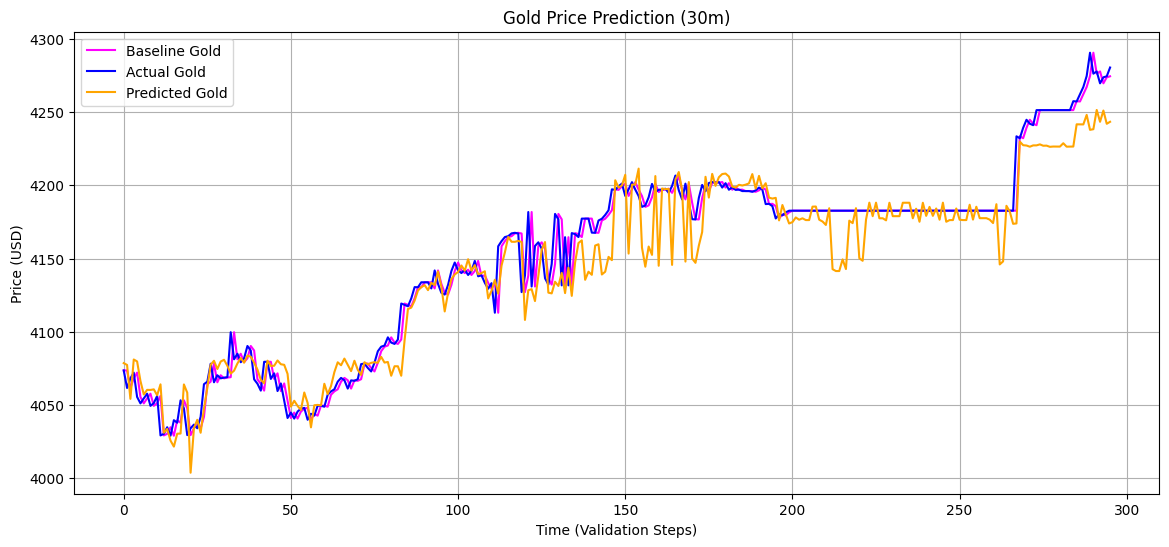

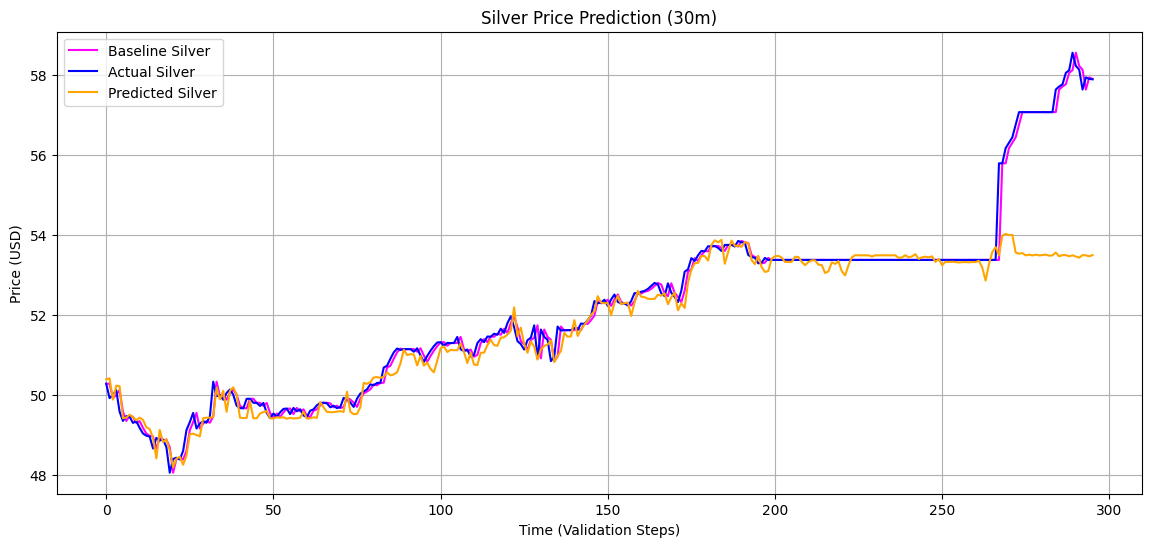

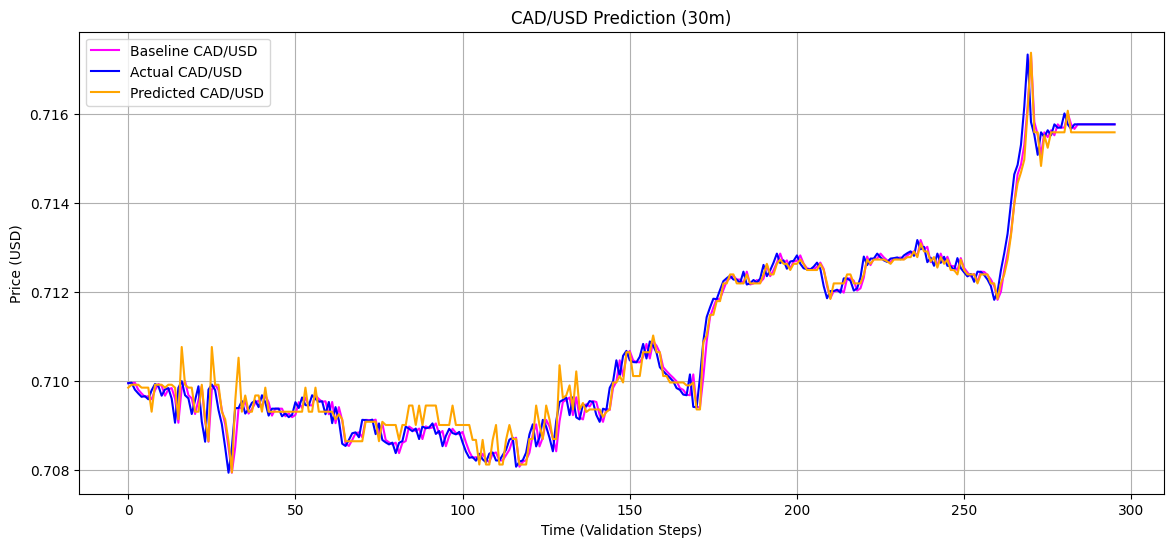

In [64]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [65]:
search_space = {
    'max_depth': Integer(3, 20),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'n_estimators': Integer (5, 30),
    'eval_metric': ['rmse', 'mae', 'mape']
}

In [66]:
n_train = int(len(X_train) * 0.70)
n_val = int(len(X_train) * 0.15)

train_indices = np.full(n_train, -1)
val_indices = np.zeros(n_val)

test_fold = np.concatenate([train_indices, val_indices])
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

In [67]:
opt = BayesSearchCV(
    XGBRegressor(tree_method="auto", random_state=42),
    search_space,
    n_iter=50,
    cv=ps,
    scoring='neg_mean_absolute_error',
    random_state=42
)

In [68]:
opt.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('mape'), 1.0, np.int64(3), np.int64(5)] before, using random point ['mae', 0.024716536178354686, np.int64(15), np.int64(21)]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('mape'), 1.0, np.int64(3), np.int64(5)] before, using random point ['mae', 0.0030728719815724817, np.int64(8), np.int64(16)]
  warnings.warn(


BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,...
                                     n_jobs=None, num_parallel_tree=None, ...),
              random_state=42, scoring='neg_mean_absolute_error',
              search_spaces={'eval_metric': ['rmse', 'mae', 'mape'],
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=30, prior='uniform', transform='normalize')})

### Metrics Evaluation

In [69]:
best_params = opt.best_params_
best_params

OrderedDict([('eval_metric', 'rmse'),
             ('learning_rate', 0.14406991201527802),
             ('max_depth', 3),
             ('n_estimators', 30)])

In [70]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [71]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [72]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

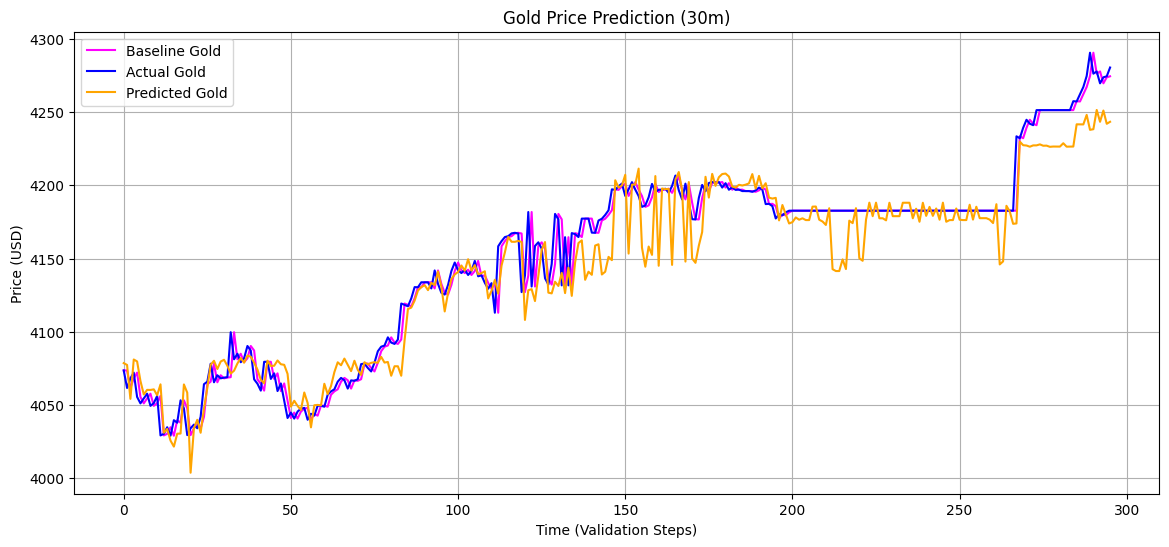

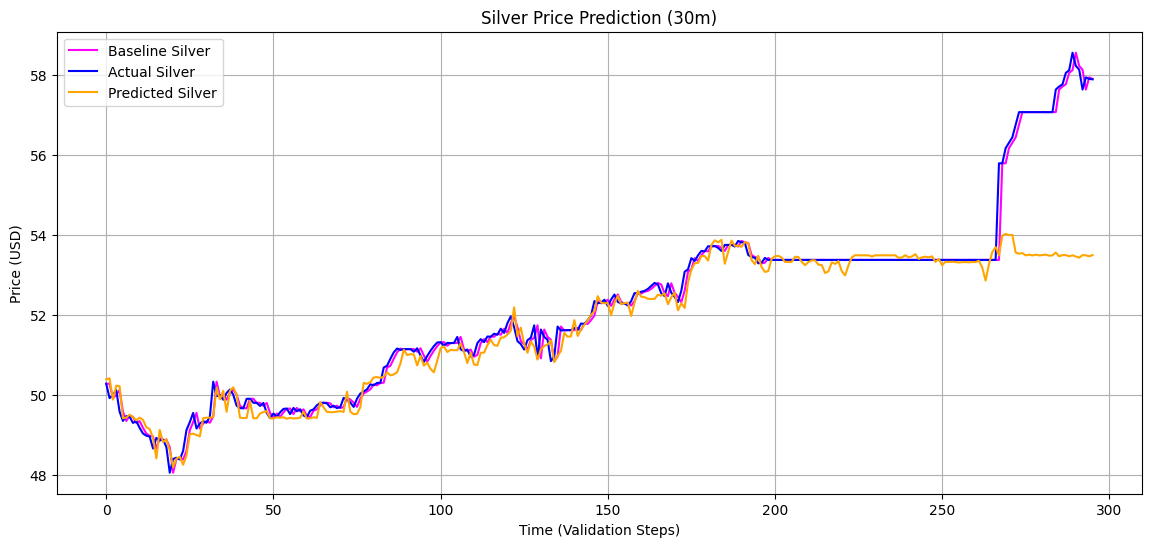

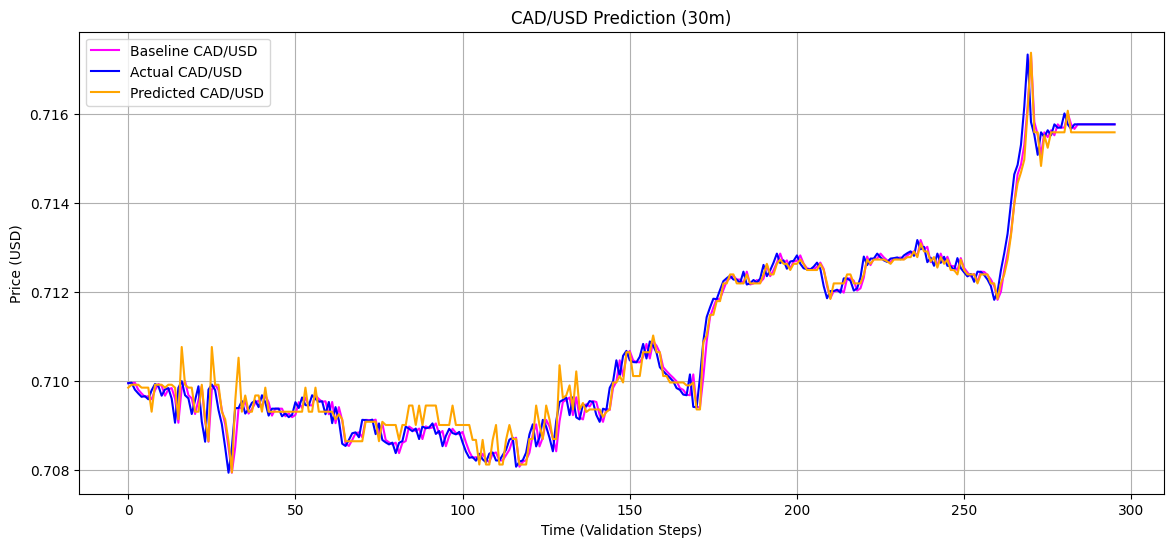

In [73]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [74]:
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Mean Absolute Error :', mae)
print('Root Mean Squared Error :', rmse)
print('Mean Absolute Percentage Error :', mape)

Mean Absolute Error : 2.4417507648468018
Root Mean Squared Error : 6.1973991968744375
Mean Absolute Percentage Error : 0.0033675236627459526


In [75]:
print("MAE:")
print("Gold  :", mean_absolute_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_error(y_test['CAD_target'], y_pred[:,2]))

print("RMSE:")
print("Gold  :", np.sqrt(mean_squared_error(y_test['Gold_target'], y_pred[:,0])))
print("Silver:", np.sqrt(mean_squared_error(y_test['Silver_target'], y_pred[:,1])))
print("CAD   :", np.sqrt(mean_squared_error(y_test['CAD_target'], y_pred[:,2])))

print("MAPE:")
print("Gold  :", mean_absolute_percentage_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_percentage_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_percentage_error(y_test['CAD_target'], y_pred[:,2]))

MAE:
Gold  : 6.87158862964527
Silver: 0.4534511952786831
CAD   : 0.0002127352195817071
RMSE:
Gold  : 10.675813058147158
Silver: 1.1181857539856395
CAD   : 0.0003007019261112405
MAPE:
Gold  : 0.0016560292150626485
Silver: 0.008147315711077265
CAD   : 0.00029923054047750145


In [76]:
best_model.save_model('xgboost_30m.json')
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.14406991201527802, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30, n_jobs=None,
             num_parallel_tree=None, ...)

# Future Predictions

In [77]:
params = XGBRegressor()
params.load_model('xgboost_30m.json')
params = params.get_xgb_params()
model = XGBRegressor(**params)

# Fit this new model on the entire dataset (X, y)
model.fit(X, y)
model

XGBRegressor(base_score=[4083.8833, 49.38851, 0.71347576], booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [78]:
def forecast_interval(model, df, start_date, end_date):

    lag = 3
    window = 5

    historical_raw_data = df[['Gold', 'Silver', 'CAD']].iloc[-window:].copy()

    predictions = []
    future_index = pd.date_range(start=start_date, end=end_date, freq="30min")

    training_columns = X.columns.tolist()

    for _ in future_index:

        current_features_dict = {}

        current_gold = historical_raw_data['Gold'].iloc[-1]
        current_silver = historical_raw_data['Silver'].iloc[-1]
        current_cad = historical_raw_data['CAD'].iloc[-1]

        current_features_dict['Gold'] = current_gold
        current_features_dict['Silver'] = current_silver
        current_features_dict['CAD'] = current_cad

        # Returns (needs current and previous)
        prev_gold = historical_raw_data['Gold'].iloc[-2]
        prev_silver = historical_raw_data['Silver'].iloc[-2]
        prev_cad = historical_raw_data['CAD'].iloc[-2]

        current_features_dict['Gold_ret'] = (current_gold - prev_gold) / prev_gold if prev_gold != 0 else 0
        current_features_dict['Silver_ret'] = (current_silver - prev_silver) / prev_silver if prev_silver != 0 else 0
        current_features_dict['CAD_ret'] = (current_cad - prev_cad) / prev_cad if prev_cad != 0 else 0

        # Moving Averages (needs last 5 values)
        current_features_dict['Gold_ma'] = historical_raw_data['Gold'].rolling(window).mean().iloc[-1]
        current_features_dict['Silver_ma'] = historical_raw_data['Silver'].rolling(window).mean().iloc[-1]
        current_features_dict['CAD_ma'] = historical_raw_data['CAD'].rolling(window).mean().iloc[-1]

        for lag in range(1, lag + 1):
            current_features_dict[f"Gold_lag_{lag}"] = historical_raw_data['Gold'].iloc[-lag-1]
            current_features_dict[f"Silver_lag_{lag}"] = historical_raw_data['Silver'].iloc[-lag-1]
            current_features_dict[f"CAD_lag_{lag}"] = historical_raw_data['CAD'].iloc[-lag-1]

        X_input_df = pd.DataFrame([current_features_dict], columns=training_columns)
        X_input = X_input_df.values.reshape(1, -1)

        y_pred = model.predict(X_input)[0]

        predictions.append(y_pred)

        historical_raw_data = historical_raw_data.iloc[1:].copy()

        new_pred_row = pd.DataFrame([y_pred], columns=['Gold', 'Silver', 'CAD'])
        historical_raw_data = pd.concat([historical_raw_data, new_pred_row], ignore_index=True)

    pred_df = pd.DataFrame(predictions, index=future_index, columns=df[['Gold', 'Silver', 'CAD']].columns)
    return pred_df

In [79]:
future_start = "2025-12-3"
future_end   = "2025-12-4"

forecast_df = forecast_interval(model, all_prices, future_start, future_end)
forecast_df

,Gold,Silver,CAD
2025-12-03 00:00:00,4280.746094,57.896301,0.715718
2025-12-03 00:30:00,4282.327148,58.096272,0.715718
2025-12-03 01:00:00,4273.483887,57.994774,0.715718
2025-12-03 01:30:00,4271.357422,57.857872,0.715718
2025-12-03 02:00:00,4273.801758,57.628403,0.715718
2025-12-03 02:30:00,4272.793945,57.604435,0.715718
2025-12-03 03:00:00,4274.559082,57.580269,0.715718
2025-12-03 03:30:00,4276.751465,57.590069,0.715718
2025-12-03 04:00:00,4276.427246,57.574543,0.715718
2025-12-03 04:30:00,4278.169434,57.580269,0.715718
